In [1]:
import numpy as np
import glob
import scipy.signal as scs
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, VoigtModel, LinearModel, ConstantModel
import CESfunctionsIASC as cf

In [2]:
calfactors=(7.090964e+02,-1.167403e-01,
            -1.903367e-05,6.759619e-09)

In [3]:
spec=np.arange(1,1025,1)

In [4]:
# Prepare reference and convolution

In [36]:
ref1=np.loadtxt("NO2.txt")
#ref2=np.loadtxt("CHOCHO.txt")
wavelengths=cf.andor_calibrator(len(spec),*calfactors)
ref1int = np.interp(wavelengths[:,0],ref1[:,0],ref1[:,1])
#ref2int = np.interp(wavelengths[:,0],ref2[:,0],ref2[:,1])

In [37]:
wavelengths

array([[708.97964067],
       [708.86284332],
       [708.74600798],
       ...,
       [577.12309042],
       [576.98862794],
       [576.85416888]])

Text(0.5, 1.0, 'Reference and Interpolation')

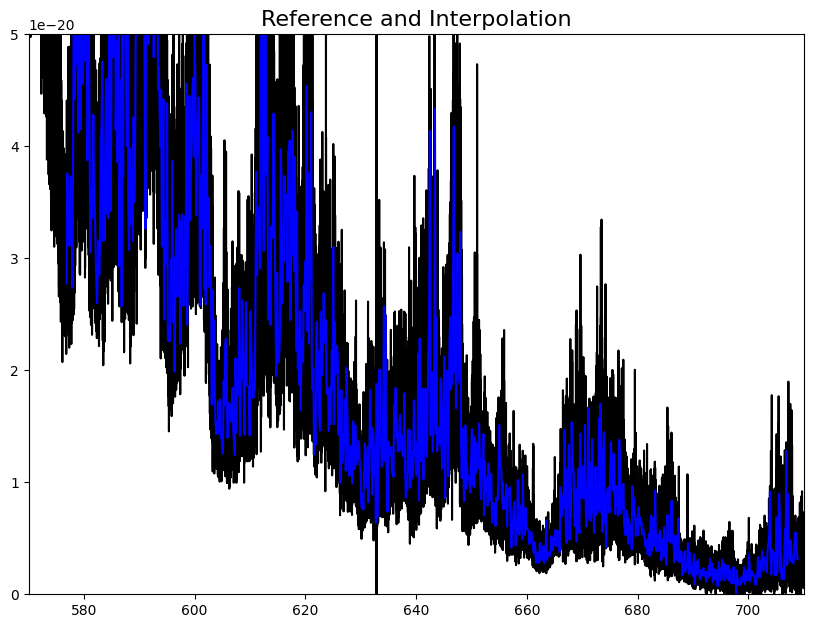

In [38]:
f = plt.figure(figsize=(10,16))
ax1 = f.add_subplot(211)
#ax2 = f.add_subplot(212)

ax1.plot(ref1[:,0],ref1[:,1],'-k')
ax1.plot(wavelengths[:,0],ref1int,'-b')
ax1.set_xlim(570,710)
ax1.set_ylim(0,.5e-19)
ax1.set_title("Reference and Interpolation",size=16)

#ax2.plot(ref2[:,0],ref2[:,1],'-k')
#ax2.plot(wavelengths[:,0],ref2int,'-b')
#ax2.set_xlim(400,470)
#ax2.set_title("Reference and Interpolation",size=16)

In [13]:
lamp=np.loadtxt('NeLampSlitON.csv',delimiter=',')
lamp_cal = np.concatenate((wavelengths[:,:],lamp[:,1].reshape(len(lamp[:,1]),1)),axis=1)

(670.0, 630.0)

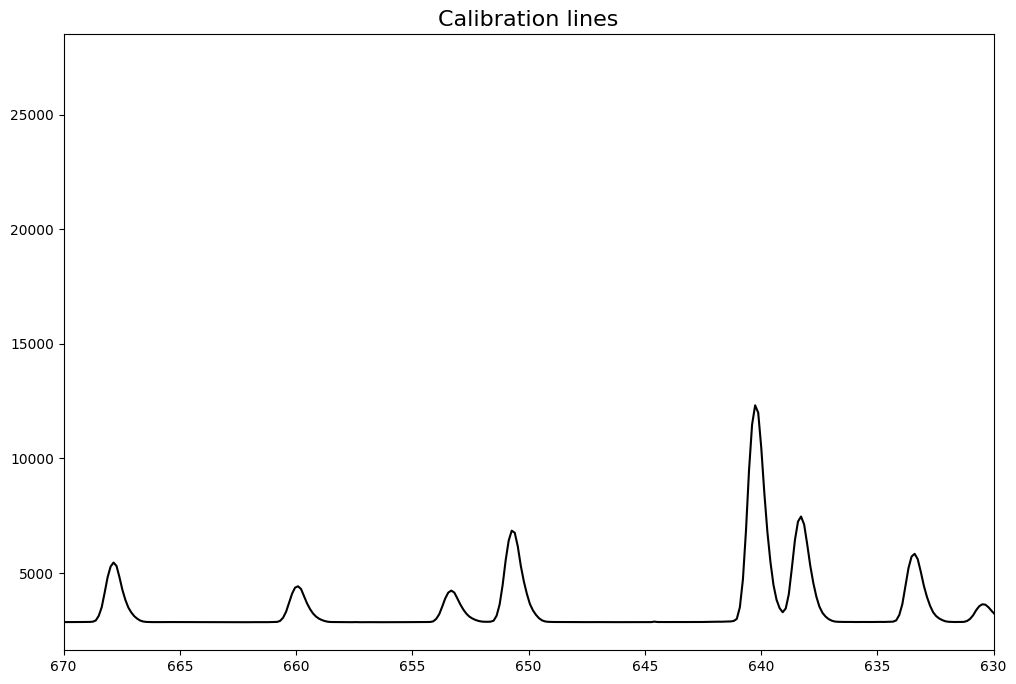

In [15]:
f = plt.figure(figsize=(12,8))
ax1 = f.add_subplot(111)

ax1.plot(lamp_cal[:,0],lamp_cal[:,1],'-k')
ax1.set_title("Calibration lines",size=16)
ax1.set_xlim(670,630)

In [16]:
### Find the line closer to your range, get its maximun, center it with and get your lineshape vector
section=np.nonzero((lamp_cal[:,0]<=662) & (lamp_cal[:,0]>=658))
center=np.nonzero(lamp_cal[:,1]==np.amax(lamp_cal[section[0][0]:section[0][-1],1]))
lineshape = np.copy(lamp_cal[center[0][0]-10:center[0][0]+11,:])
lineshape[:,1]=lineshape[:,1]-np.amin(lineshape[:,1])
lineshape[:,1]=(lineshape[:,1])/(np.amax(lineshape[:,1]))
np.amin(lineshape[:,1])

0.0

In [19]:
### Let's fit the lineshape to some Gaussian and Voigt profiles using lmfit
model = GaussianModel()
model2 = VoigtModel()

# create parameters with initial values
params = model.make_params(amplitude=1, center=660,sigma=.5)
params2 = model2.make_params(amplitude=1, center=660,sigma=.5)

# maybe place bounds on some parameters
#params['center'].min = 2
#params['center'].max = 12
#params['amplitude'].max = 0. 

# do the fit, print out report with results 
result = model.fit(lineshape[:,1], params, x=lineshape[:,0])
result2 = model2.fit(lineshape[:,1], params2, x=lineshape[:,0])
print(result.fit_report())
print(result2.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 21
    # variables        = 3
    chi-square         = 0.02793644
    reduced chi-square = 0.00155202
    Akaike info crit   = -133.069260
    Bayesian info crit = -129.935692
    R-squared          = 0.98914733
[[Variables]]
    amplitude:  0.87495199 +/- 0.01925535 (2.20%) (init = 1)
    center:     659.909350 +/- 0.00887133 (0.00%) (init = 660)
    sigma:      0.34907157 +/- 0.00887114 (2.54%) (init = 0.5)
    fwhm:       0.82200070 +/- 0.02088994 (2.54%) == '2.3548200*sigma'
    height:     0.99995357 +/- 0.02200766 (2.20%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5773
[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 21
    # variables        = 3
    chi-square         = 0.04850369
 

Text(0.5, 1.0, 'Line shape and fits')

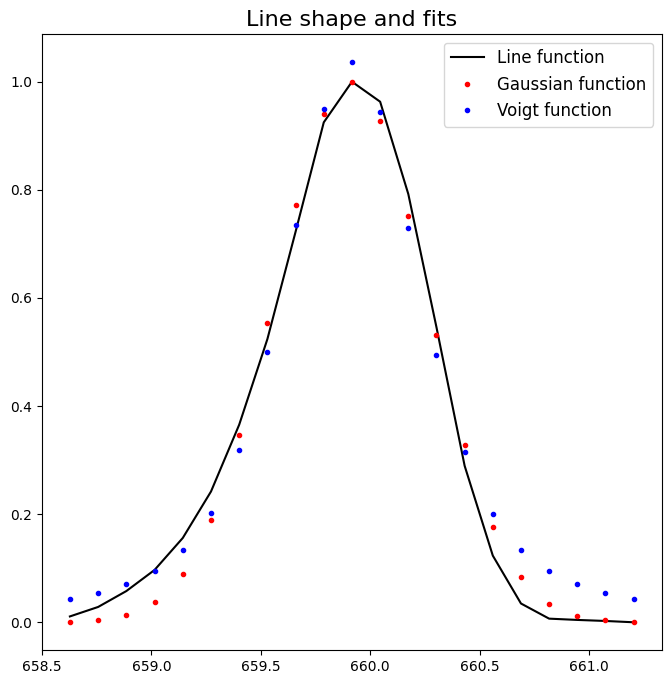

In [20]:
f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(111)
ax1.plot(lineshape[:,0],lineshape[:,1]-np.amin(lineshape[:,1]),'-k',label="Line function")
ax1.plot(lineshape[:,0],result.best_fit,'.r',label="Gaussian function")
ax1.plot(lineshape[:,0],result2.best_fit,'.b',label="Voigt function")
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("Line shape and fits",size=16)

In [39]:
### Perform the convolution with the original lineshape and the fits
conv11 = np.convolve(ref1int,lineshape[:,1],mode='same')
#conv12 = np.convolve(ref2int,lineshape[:,1],mode='same')
conv21 = np.convolve(ref1int,result.best_fit,mode="same")
#conv22 = np.convolve(ref2int,result.best_fit,mode="same")
conv31 = np.convolve(ref1int,result2.best_fit,mode="same")
#conv32 = np.convolve(ref2int,result2.best_fit,mode="same")

Text(0.5, 1.0, 'NO3 reference convolutions')

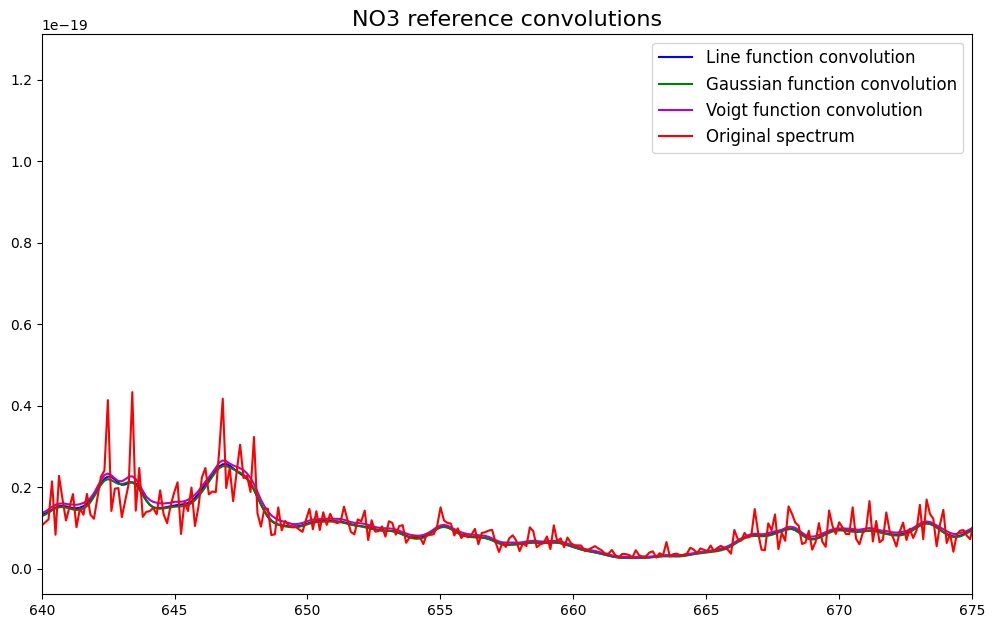

In [40]:
f = plt.figure(figsize=(12,16))
ax1 = f.add_subplot(211)
#ax2 = f.add_subplot(212)
a1=6.5
b1=.01e-19
ax1.plot(wavelengths[:,0],conv11/a1-b1,'-b',label="Line function convolution")
ax1.plot(wavelengths[:,0],conv21/a1-b1,'-g',label="Gaussian function convolution")
ax1.plot(wavelengths[:,0],conv31/a1-b1,'-m',label="Voigt function convolution")
#ax1.plot(wavelengths[:,0],conv11/a-b,'-k',label="Line function convolution (adjusted)")
ax1.plot(wavelengths[:,0],ref1int,'-r',label="Original spectrum")
ax1.set_xlim(640,675)
ax1.legend(fontsize=12, loc='upper right')
ax1.set_title("NO3 reference convolutions",size=16)
#aref = np.trapz(ref1int[275:500])
#a11 = np.trapz(conv11[275:500]/a-b)
#a12 = np.trapz(conv11[275:500]/a-b)
#a13 = np.trapz(conv11[275:500]/a-b)
#print(aref,a11,a12,a13)
#a2=4.25
#b2=0
#ax2.plot(wavelengths[:,0],conv12/a2-b2,'-b',label="Line function convolution")
#ax2.plot(wavelengths[:,0],conv22/a2-b2,'-g',label="Gaussian function convolution")
#ax2.plot(wavelengths[:,0],conv32/a2-b2,'-m',label="Voigt function convolution")
#ax2.plot(wavelengths[:,0],conv12/6,'-k',label="Line function convolution (adjusted)")
#ax2.plot(wavelengths[:,0],ref2int,'-r',label="Original spectrum")
#ax2.set_xlim(425,465)
#ax2.legend(fontsize=12, loc='upper right')
#ax2.set_title("Reference 2 convolutions",size=16)

In [41]:
ref1conv=conv11/a1-b1
#ref2conv=conv12/a2-b2

np.save("NO2_IASC_3",np.concatenate((wavelengths,ref1conv.reshape(len(ref1conv),1)),axis=1))
#np.save("CHOCHO_IASC_1",np.concatenate((wavelengths,ref2conv.reshape(len(ref2conv),1)),axis=1))

In [42]:
### making the extinction spectrum

In [43]:
wls = wavelengths
sigmas_N2 = []
for wl in wls:
    wn = (1/wl)*1e7
    a = 5677.465
    b = 318.81874e12
    c = 14.4e9
    N = 2.546899e19
    Fk = 1.034+3.17e-12*np.power(wn,2)
    pre_n = a + (b/(c-np.power(wn,2))) 
    n = (pre_n/1e8)+1
    sigma_1st = 24 * np.power(np.pi,3) * np.power(wn,4)/np.power(N,2)
    sigma_2nd = (np.power(n,2)-1)/(np.power(n,2)+2)
    sigma = sigma_1st * np.power(sigma_2nd,2)*Fk
    sigmas_N2.append(sigma[0])

sigmas_O2 = []
for wl in wls:
    wn = (1/wl)*1e7
    a = 20564.8
    b = 2.480899e13
    c = 4.09e9
    N = 2.68678e19
    Fk = 1.096+1.385e-11*np.power(wn,2)+1.448e-20*np.power(wn,4)
    pre_n = a + (b/(c-np.power(wn,2))) 
    n = (pre_n/1e8)+1
    sigma_1st = 24 * np.power(np.pi,3) * np.power(wn,4)/np.power(N,2)
    sigma_2nd = (np.power(n,2)-1)/(np.power(n,2)+2)
    sigma = sigma_1st * np.power(sigma_2nd,2)*Fk
    sigmas_O2.append(sigma[0])
    
sigmas_Ar = []
for wl in wls:
    wn = (1/wl)*1e7
    a = 6432.135
    b = 286.06021e12
    c = 14.4e9
    N = 2.546899e19
    Fk = 1
    pre_n = a + (b/(c-np.power(wn,2))) 
    n = (pre_n/1e8)+1
    sigma_1st = 24 * np.power(np.pi,3) * np.power(wn,4)/np.power(N,2)
    sigma_2nd = (np.power(n,2)-1)/(np.power(n,2)+2)
    sigmaAr = sigma_1st * np.power(sigma_2nd,2)*Fk
    sigmas_Ar.append(sigma[0])
sigma_Air = np.array(sigmas_N2)*.78084+np.array(sigmas_O2)*.20947+np.array(sigmas_Ar)*.00934

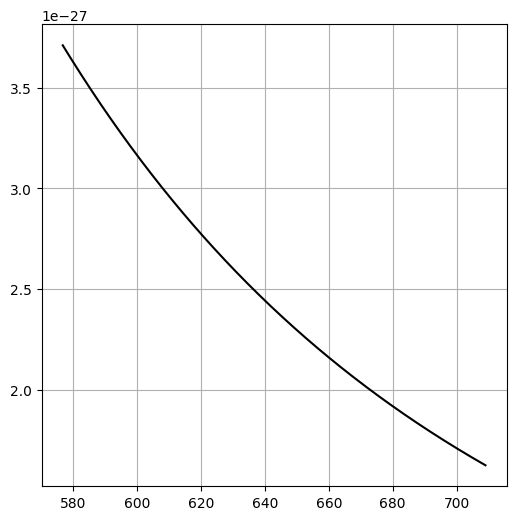

In [44]:
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(111)

#ax1.plot(wls[minwave:maxwave],sigma_Air[minwave:maxwave],'-k')

ax1.plot(wls,sigma_Air,'-k')
ax1.grid()

In [24]:
no2reference= np.load('NO2_IASC_2.npy')
minwave,maxwave = cf.segment_indices(no2reference,650,
                453)
np.save('sigma_ray_short',sigma_Air[minwave:maxwave])
np.save('sigma_ray',sigma_Air)